 Задача №1 — семантический текстовый поиск


Команда проекта **"НейроЭмоции"** (MIFIML):
1. Бикбулатова Айгуль Ришатовна.
2. Борзунов Антон Андреевич.
3. Булахов Юрий Эдуардович.
4. Ворошнина Анна Олеговна.
5. Голунов Артем Сергеевич.
6. Ситёв Роман Рустамович.
7. Чунарев Дмитрий Дмитриевич.

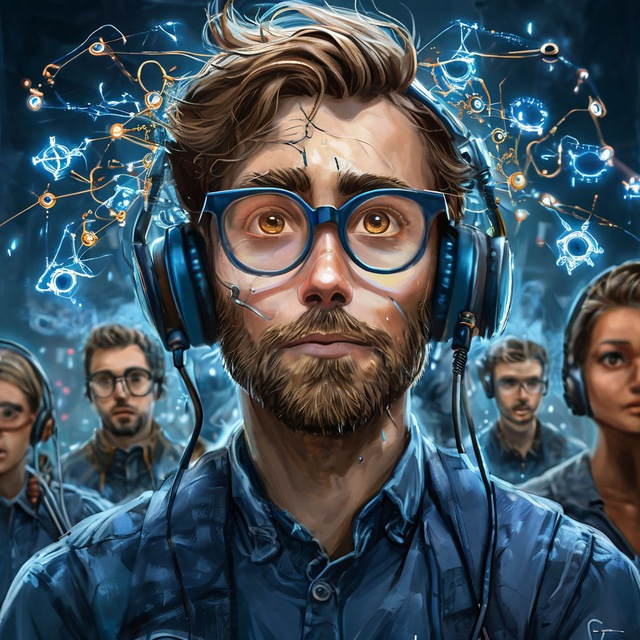

**Цель и ожидаемый результат**

Создать систему семантического текстового поиска слов (словосочетаний) в документах, учитывающую не только точное написание, но и смысловое значение.
Результатом должно быть определение позиции найденного слова/словосочетания в тексте и оценка вероятности совпадения. Желательно реализовать примитивный веб-интерфейс (UI) для ручного тестирования.

**Технические требования**
- Кодовая база на языке Python;
- все тексты только на русском языке в нижнем регистре без пунктуации;
- максимальная длина документа – 30 слов;
- словосочетание состоит не более чем из 2 слов в базовой форме.
- примеры работы программы прилагаются
- время отработки документа на GPU не более 0.5 сек
- объем занимаемой видеопамяти не более 5 Гб

**Критерии оценки**

- PEP8-оформление, docstrings;

- Оформление проекта по шаблону (например, cookiecutter);

- Документация этапов: подготовка данных, обучение, валидация, эксплуатация;

- Возможность запуска через CLI и предпочтительно через Docker;

- requirements.txt с четким списком библиотек и их версий;

- Инструкция по созданию собственного датасета;

- Метрики качества (доля пропусков, ложных срабатываний и др.) с интерпретацией;

- Покрытие кода модульными тестами;

- Информативность экспериментов: какие данные, модели, гиперпараметры, функции ошибки использовались;

***Главный критерий — качество предсказаний на закрытых тестовых данных.***

**Критерии оценки от партнера:**

- Код оформлен в соответствие со стандартом PEP8 (docstring функций, методов, классов);
- Проект организован по шаблону, например cookiecutter;
- Основные этапы проекта (подготовка данных, обучение, валидация, эксплуатация) задокументированы, и их запуск возможен через CLI;
- Предпочтителен запуск проекта через docker контейнер;
- Задан четкий список необходимых библиотек и фреймворков с их версиями (requirements.txt)
- Документация по созданию своего датасета для применения в проекте;
- Разнообразие метрик оценки предсказаний (доля пропусков, доля ложных срабатываний и т.д.);
- Предоставление описаний метрик. Как интерпретировать каждую метрику.
- Покрытие кода модульными тестами;
- Информативность экспериментов по обучению и валидации. Какие были использованы данные, гиперпараметры, модели, функции ошибки и всё, что повлияло на полученные метрики эксперимента;
- Наилучшие метрики на закрытых тестовых данных (едины для всех команд).

# **1. Исследование и предобработка данных**

In [2]:
# Загружаем библиотеки
import numpy as np
import pandas as pd
from google.colab import drive
import os
import re
from collections import Counter
import string
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

from collections import defaultdict
import math
import torch
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


# Загружаем инструменты NLP для великого и могучего русского языка (оставляем только Natasha, пробовал Stanza и Pullenti, получилась ерунда)
!pip install natasha razdel
from natasha import (
    Doc,
    MorphVocab,
    Segmenter,
    NewsEmbedding,
    NewsMorphTagger
)

# Инициализация компонентов Natasha
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

# Стоп-слова (Флюгегехаймен)
russian_stopwords = [
    'и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а',
    'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же',
    'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от',
    'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже',
    'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него',
    'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом',
    'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо',
    'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без',
    'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда',
    'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним',
    'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас',
    'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец',
    'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через',
    'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три',
    'эту', 'моя', 'впрочем', 'хорошо', 'свою', 'этой', 'перед', 'иногда',
    'лучше', 'чуть', 'том', 'нельзя', 'такой', 'им', 'более', 'всегда',
    'конечно', 'всю', 'между'
]

social_stopwords = ['http', 'https', 'com', 'www', 't.me', 'youtu.be', 'vk.cc', 'ссылка', 'прикреплённые', '🔗']
russian_stopwords.extend(social_stopwords)

In [3]:
# Загружем все файлы, любезно предоставленные компанией Норси-Транс
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive//'
dfs = [pd.read_csv(f'{data_path}{i}.csv') for i in range(1, 7)]

# Объединяем все датасеты
data = pd.concat(dfs, ignore_index=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Проверяем структуру данных
print(f"Всего записей: {len(data)}")
print("\nПервые 5 записей:")
display(data.head())

Всего записей: 6000

Первые 5 записей:


,doc_text,image2text,speech2text
0,Твой лучший секс спрятан здесь 🔞 Делюсь канал...,NaN,NaN
1,⭐️ Кнопка: ⭐️START⭐️(https://t.me/major/start...,NaN,NaN
2,А продолжение где? Правильно. В моем сообществ...,девчонки не умеют переписываться sanille они э...,NaN
3,Тем временем моя авторская телега уверенно в т...,10:42 nuil пул telegram ^ 51 142 подписчика 12...,NaN
4,"У меня есть двоюродная сестра, у нее есть сын ...","т с не ^ е z 8 * \""8 ничего не знала о стендап...",NaN


In [6]:
print("\nИнформация об объедииненном датасете:")
display(data.info())  # Проверим на пропущенные значения
print("\nПропущенные значения по колонкам:")
display(data.isnull().sum())


Информация об объедииненном датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   doc_text     6000 non-null   object
 1   image2text   3420 non-null   object
 2   speech2text  1871 non-null   object
dtypes: object(3)
memory usage: 140.8+ KB


None


Пропущенные значения по колонкам:


,0
doc_text,0
image2text,2580
speech2text,4129


In [7]:
# Проверим на пустые строки
print("\nПустые строки по колонкам:")
display(data.apply(lambda x: x.str.strip().eq('')).sum())


Пустые строки по колонкам:


,0
doc_text,0
image2text,0
speech2text,0


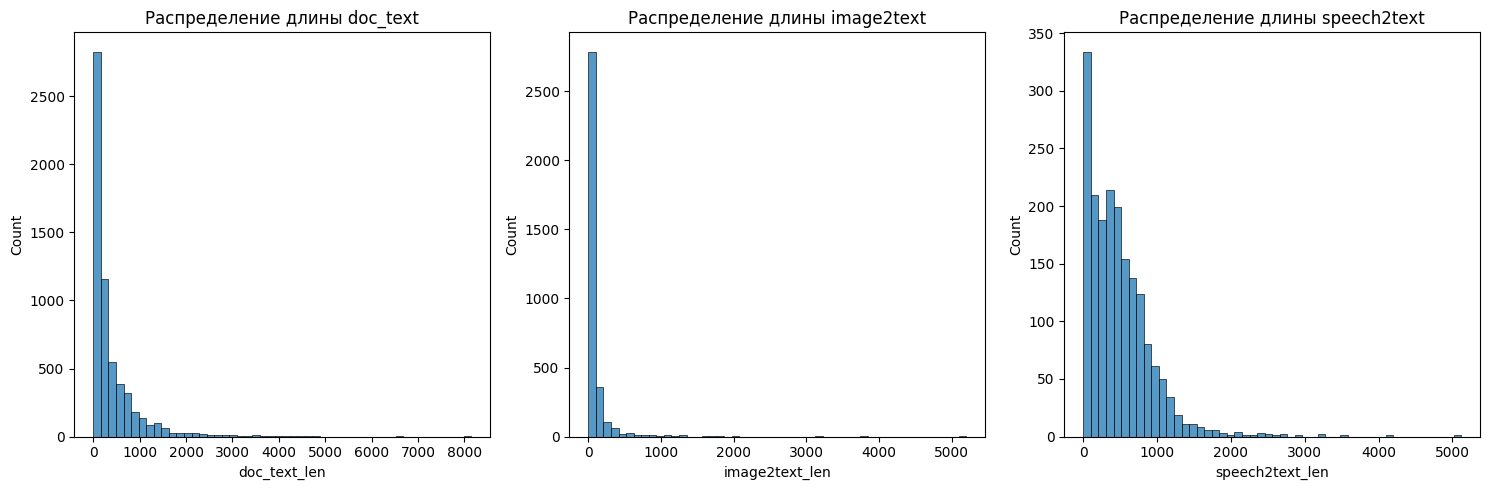

In [8]:
# Проанализируем длину текста
data['doc_text_len'] = data['doc_text'].str.len()
data['image2text_len'] = data['image2text'].str.len()
data['speech2text_len'] = data['speech2text'].str.len()

# Посмотрим на графике
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(data['doc_text_len'].dropna(), bins=50)
plt.title('Распределение длины doc_text')

plt.subplot(1, 3, 2)
sns.histplot(data['image2text_len'].dropna(), bins=50)
plt.title('Распределение длины image2text')

plt.subplot(1, 3, 3)
sns.histplot(data['speech2text_len'].dropna(), bins=50)
plt.title('Распределение длины speech2text')

plt.tight_layout()
plt.show()

In [9]:
# Почистим данные
def clean_text(text):
    if pd.isna(text) or text.strip() == '':
        return np.nan

    # Удаление URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+\.(com|ru|net|org)\S*', '', text)

    # Удаление специальных символов и эмодзи
    text = re.sub(r'[^\w\s]|[\U00010000-\U0010ffff]', ' ', text)

    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()

    return text if text != '' else np.nan

# Применение очистки ко всем текстовым колонкам
data['doc_text_clean'] = data['doc_text'].apply(clean_text)
data['image2text_clean'] = data['image2text'].apply(clean_text)
data['speech2text_clean'] = data['speech2text'].apply(clean_text)

# Удалим полностью пустые строчки
initial_count = len(data)
data = data.dropna(how='all', subset=['doc_text_clean', 'image2text_clean', 'speech2text_clean'])
print(f"\nУдалено полностью пустых записей: {initial_count - len(data)}")

# Проверим дубликаты
print("\nКоличество дубликатов по колонкам:")
display(pd.DataFrame({
    'doc_text': [data.duplicated(subset=['doc_text_clean']).sum()],
    'image2text': [data.duplicated(subset=['image2text_clean']).sum()],
    'speech2text': [data.duplicated(subset=['speech2text_clean']).sum()]
}))

# Удалим дубликаты
data = data.drop_duplicates(subset=['doc_text_clean'], keep='first')
data = data.drop_duplicates(subset=['image2text_clean'], keep='first')
data = data.drop_duplicates(subset=['speech2text_clean'], keep='first')
print(f"\nОсталось записей после удаления дубликатов: {len(data)}")


Удалено полностью пустых записей: 28

Количество дубликатов по колонкам:


,doc_text,image2text,speech2text
0,681,3198,4293



Осталось записей после удаления дубликатов: 961


# **2. Лингвистическая обработка**

In [10]:
# Предварительная обработка
def preprocess_text(text):
    """Функция предобработки текста с использованием Натали"""
    if pd.isna(text):
        return np.nan

    text = str(text).lower()
    doc = Doc(text)

    # Сегментация на токены
    doc.segment(segmenter)

    # Морфологический разбор
    doc.tag_morph(morph_tagger)

    # Нормализация
    for token in doc.tokens:
        token.lemmatize(morph_vocab)

    # Сбор лемм с фильтрацией
    lemmas = []
    for token in doc.tokens:
        token_text = token.text

        # Пропускаем пунктуацию, стоп-слова и не-слова
        if (token_text in string.punctuation or
            token_text in russian_stopwords or
            not token_text.isalpha()):
            continue

        lemmas.append(token.lemma)

    return ' '.join(lemmas) if lemmas else np.nan

# Применяем обработку к текстовым колонкам
text_columns = ['doc_text_clean', 'image2text_clean', 'speech2text_clean']
for col in text_columns:
    processed_col = col.replace('_clean', '_processed')
    data[processed_col] = data[col].progress_apply(preprocess_text)

# Удалим полностью пустые записи
data = data.dropna(
    how='all',
    subset=['doc_text_processed', 'image2text_processed', 'speech2text_processed']
)

print(f"\nОсталось записей после обработки: {len(data)}")

100%|██████████| 961/961 [00:16<00:00, 59.78it/s]


Осталось записей после обработки: 961



Топ-30 слов в doc_text:
[('это', 264), ('стендап', 242), ('который', 142), ('человек', 122), ('год', 114), ('новый', 113), ('наш', 112), ('свой', 111), ('мой', 85), ('женский', 82), ('тнт', 77), ('весь', 76), ('смотреть', 75), ('матч', 75), ('россия', 74), ('выпуск', 72), ('видео', 71), ('такой', 70), ('самый', 66), ('день', 63), ('канал', 58), ('каждый', 55), ('один', 53), ('ваш', 53), ('мочь', 51), ('сегодня', 51), ('полный', 50), ('хотеть', 50), ('очень', 49), ('ребенок', 49)]

Топ-30 слов в image2text:
[('v', 50), ('видео', 49), ('м', 36), ('w', 33), ('это', 29), ('е', 28), ('т', 27), ('х', 27), ('эксклюзивно', 25), ('эфир', 22), ('i', 21), ('прямой', 21), ('th', 20), ('tht', 19), ('n', 18), ('s', 18), ('l', 18), ('мой', 16), ('подруга', 16), ('r', 15), ('п', 15), ('з', 14), ('вопрос', 14), ('вообще', 13), ('город', 13), ('winline', 13), ('смотреть', 12), ('полный', 12), ('г', 12), ('матч', 12)]

Топ-30 слов в speech2text:
[('это', 1314), ('говорить', 344), ('такой', 341), ('котор

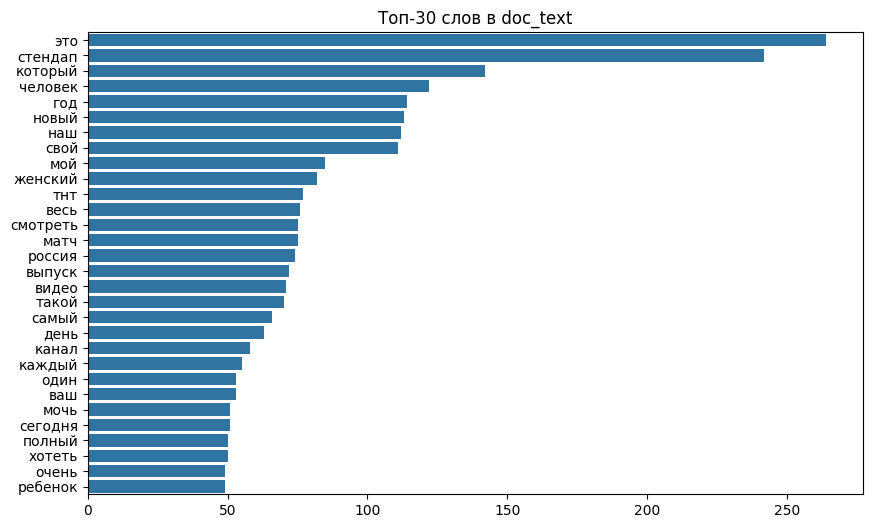

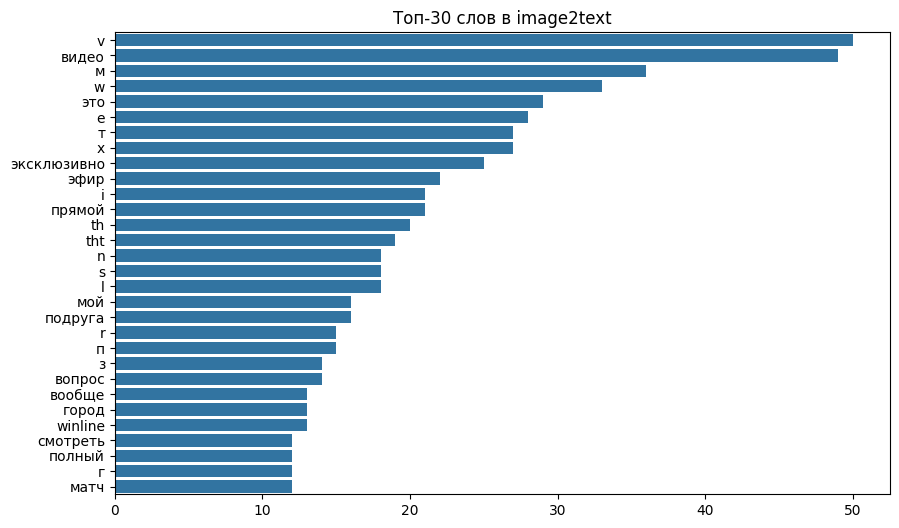

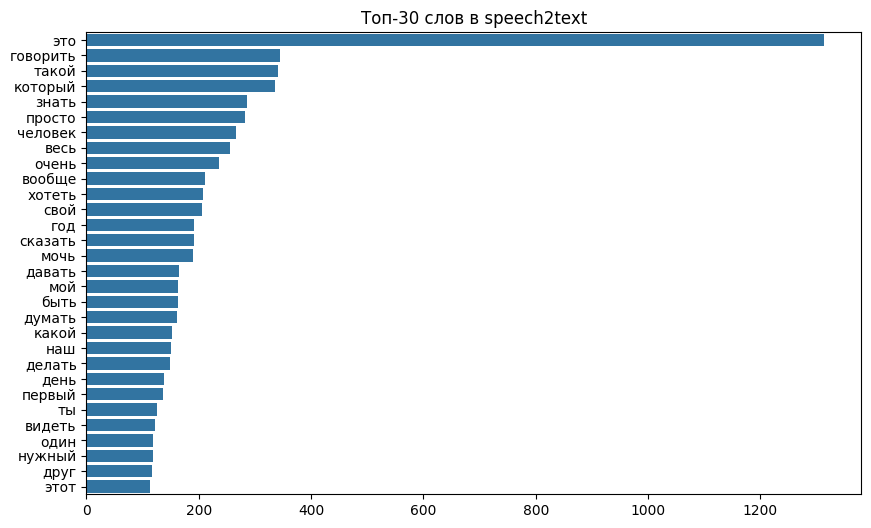

In [11]:
# Проанализируем частоту слов
def get_word_freq(series):
    all_words = []
    for text in series.dropna():
        all_words.extend(text.split())
    return Counter(all_words)

# Частота слов в каждой колонке
doc_word_freq = get_word_freq(data['doc_text_processed'])
image_word_freq = get_word_freq(data['image2text_processed'])
speech_word_freq = get_word_freq(data['speech2text_processed'])

# Топ-30 слов в каждой колонке
print("\nТоп-30 слов в doc_text:")
print(doc_word_freq.most_common(30))

print("\nТоп-30 слов в image2text:")
print(image_word_freq.most_common(30))

print("\nТоп-30 слов в speech2text:")
print(speech_word_freq.most_common(30))

# Посмотрим на графике
def plot_top_words(word_freq, title):
    top_words = word_freq.most_common(30)
    words, counts = zip(*top_words)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(title)
    plt.show()

plot_top_words(doc_word_freq, 'Топ-30 слов в doc_text')
plot_top_words(image_word_freq, 'Топ-30 слов в image2text')
plot_top_words(speech_word_freq, 'Топ-30 слов в speech2text')

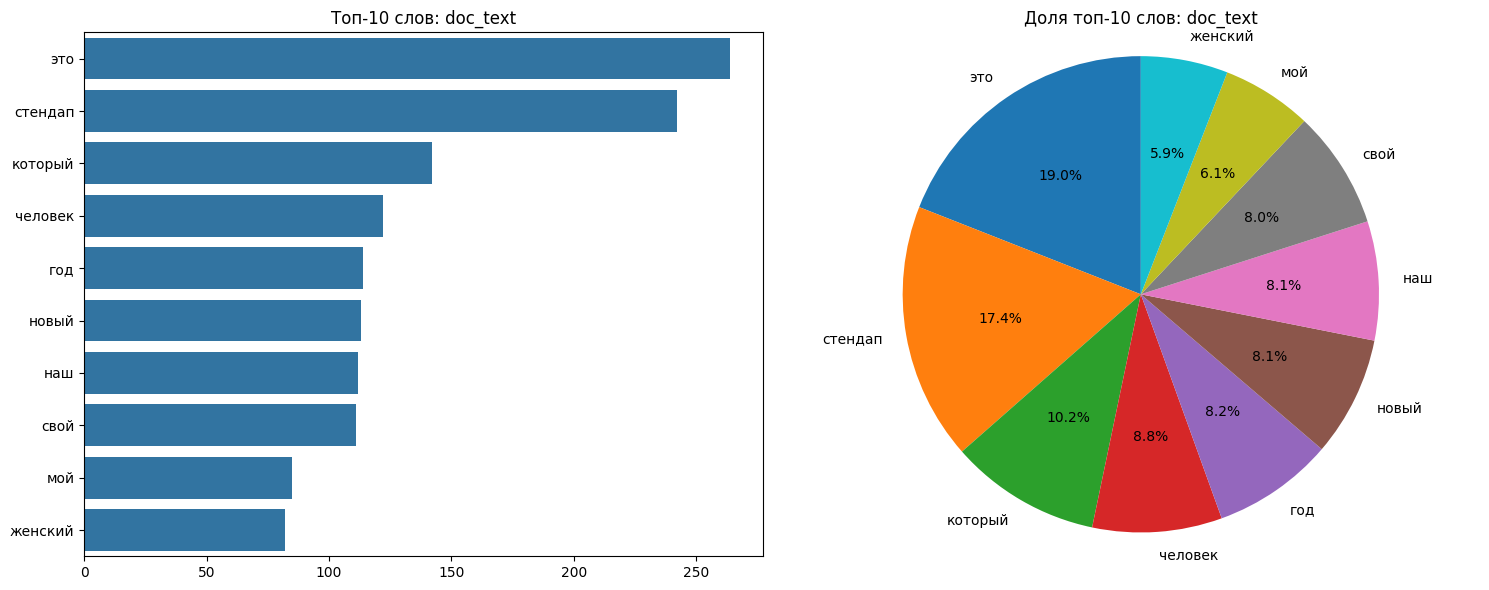

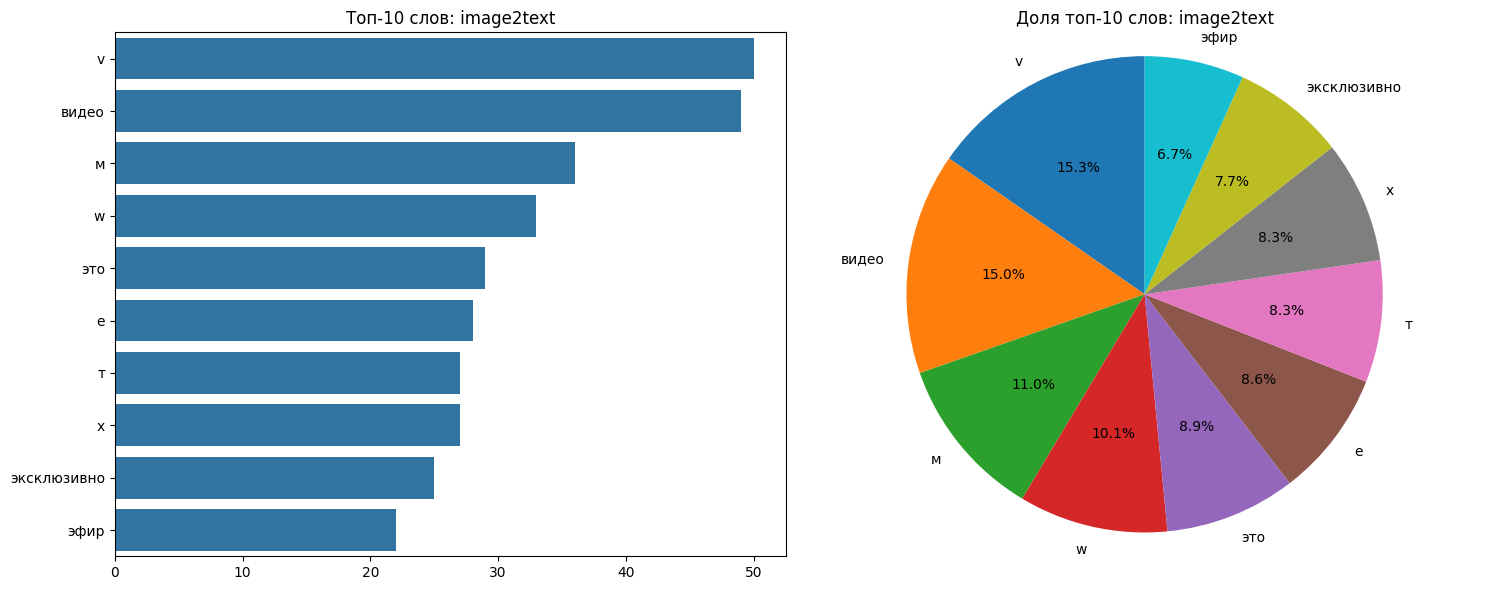

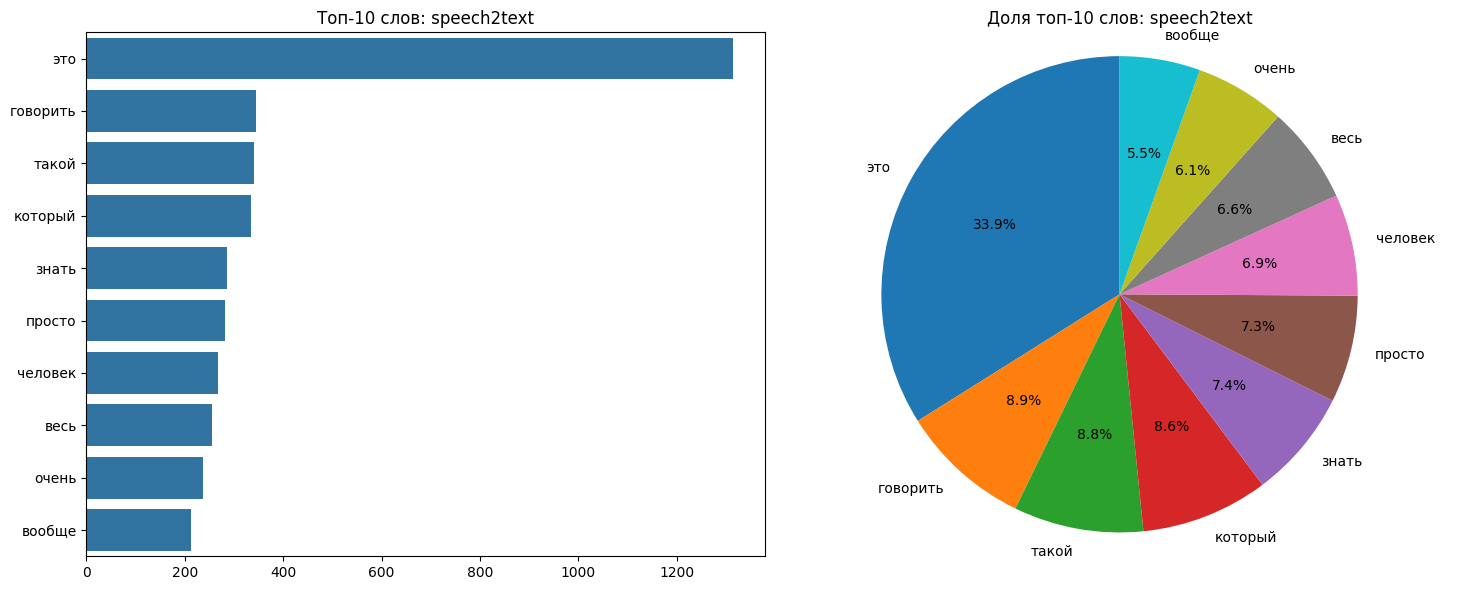

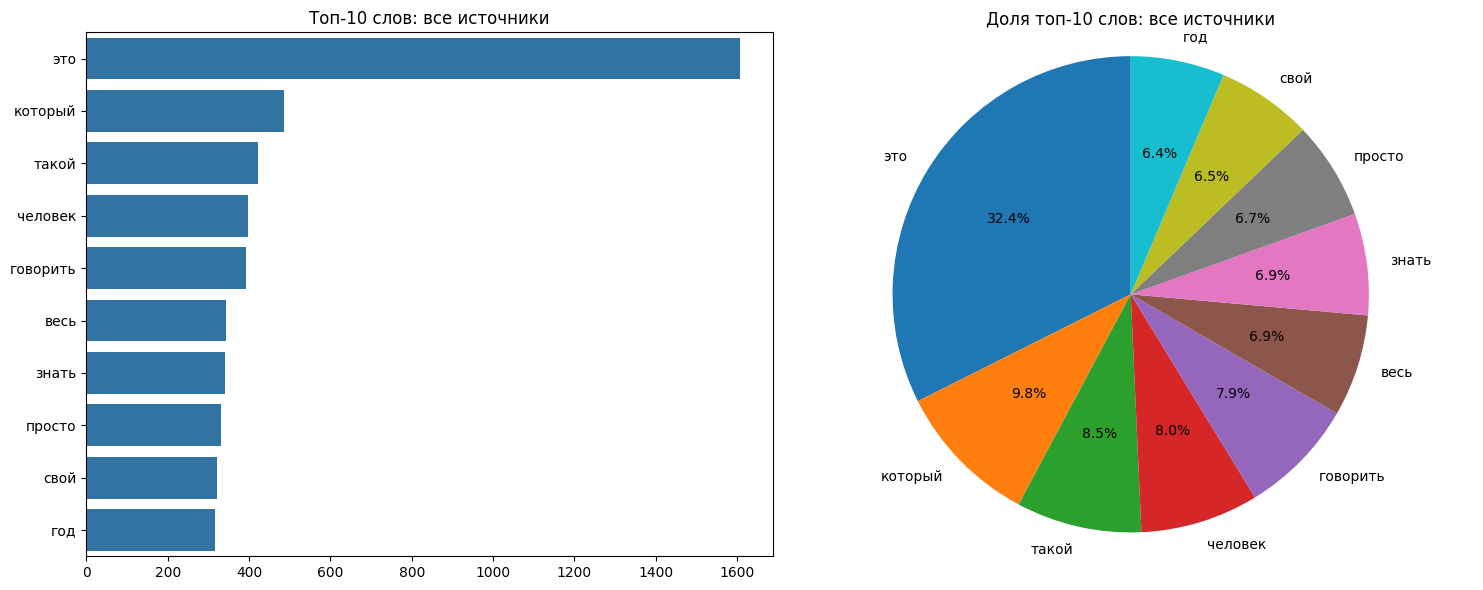

In [12]:
# Посмотрим поподробнее на ТОП-10
def plot_word_stats(word_freq, title):
    top_words = word_freq.most_common(10)
    words, counts = zip(*top_words)
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f'Топ-10 слов: {title}')
    plt.subplot(1, 2, 2)
    plt.pie(counts, labels=words, autopct='%1.1f%%', startangle=90)
    plt.title(f'Доля топ-10 слов: {title}')
    plt.axis('equal')  # Чтобы диаграмма была круглой
    plt.tight_layout()
    plt.show()

# Построим графики
plot_word_stats(doc_word_freq, 'doc_text')
plot_word_stats(image_word_freq, 'image2text')
plot_word_stats(speech_word_freq, 'speech2text')

# Дополнительно посмотрим объединенную статистику
all_word_freq = doc_word_freq + image_word_freq + speech_word_freq
plot_word_stats(all_word_freq, 'все источники')

In [13]:
# Сохраним наши результаты в новый CSV файл
output_columns = ['doc_text_processed',
                 'image2text_processed',
                 'speech2text_processed']

data[output_columns].to_csv('NeuroEmotions_data.csv', index=False, encoding='utf-8-sig', sep=';')
print("\nОбработанные данные сохранены в 'NeuroEmotions_data.csv'")


Обработанные данные сохранены в 'NeuroEmotions_data.csv'


# **3. Подготовка моделей**

## TFIDF (отказались)

In [14]:
class TFIDFVectorizer:
    def __init__(self):
        self.vocab = {}
        self.idf = {}
        self.doc_count = 0

    def preprocess(self, text):
        """Очистка текста и токенизация"""
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        return text.split()

    def fit(self, documents):
        """Обучение модели на коллекции документов"""
        self.doc_count = len(documents)
        word_doc_count = defaultdict(int)

        # Построение словаря и подсчет документов, содержащих слово
        for doc in documents:
            words = set(self.preprocess(doc))
            for word in words:
                word_doc_count[word] += 1

        # Создание словаря и расчет IDF
        self.vocab = {word: idx for idx, word in enumerate(word_doc_count.keys())}
        for word, count in word_doc_count.items():
            self.idf[word] = math.log((self.doc_count + 1) / (count + 1)) + 1

    def transform(self, text):
        """Преобразование текста в вектор TF-IDF"""
        words = self.preprocess(text)
        tf = defaultdict(float)

        # Подсчет TF (частоты терминов)
        for word in words:
            tf[word] += 1 / len(words)

        # Создание вектора TF-IDF
        vector = np.zeros(len(self.vocab))
        for word, freq in tf.items():
            if word in self.vocab:
                vector[self.vocab[word]] = freq * self.idf.get(word, 0)
        return vector

class SemanticSearch:
    def __init__(self):
        self.vectorizer = TFIDFVectorizer()
        self.documents = []
        self.doc_vectors = []

    def index(self, documents):
        """Индексация документов"""
        self.documents = documents
        self.vectorizer.fit(documents)
        self.doc_vectors = [self.vectorizer.transform(doc) for doc in documents]

    def cosine_similarity(self, vec_a, vec_b):
        """Косинусная схожесть между векторами"""
        if np.linalg.norm(vec_a) == 0 or np.linalg.norm(vec_b) == 0:
            return 0
        return np.dot(vec_a, vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

    def find_positions(self, text, phrase):
        """Поиск позиций фразы в тексте"""
        text_lower = text.lower()
        phrase_lower = phrase.lower()
        start_pos = text_lower.find(phrase_lower)
        if start_pos != -1:
            return [(start_pos, start_pos + len(phrase))]
        return []

    def expand_query(self, query, top_n=3):
        """Расширение запроса семантически близкими словами"""
        query_vec = self.vectorizer.transform(query)
        word_scores = []

        for word in self.vectorizer.vocab:
            word_vec = np.zeros(len(self.vectorizer.vocab))
            if word in self.vectorizer.vocab:
                word_vec[self.vectorizer.vocab[word]] = self.vectorizer.idf[word]
                similarity = self.cosine_similarity(query_vec, word_vec)
                word_scores.append((word, similarity))

        # Сортировка по убыванию схожести
        word_scores.sort(key=lambda x: -x[1])
        expanded = [word for word, score in word_scores[:top_n] if score > 0.5]
        return expanded + [query]

    def search(self, query, threshold=0.5, top_k=5):
        """Семантический поиск"""
        # Расширение запроса
        expanded_queries = self.expand_query(query)
        all_results = []

        for q in expanded_queries:
            query_vec = self.vectorizer.transform(q)

            for doc_id, doc in enumerate(self.documents):
                similarity = self.cosine_similarity(query_vec, self.doc_vectors[doc_id])

                if similarity > threshold:
                    positions = self.find_positions(doc, q)
                    if not positions:
                        # Если точное совпадение не найдено, ищем отдельные слова
                        for word in q.split():
                            positions.extend(self.find_positions(doc, word))

                    all_results.append({
                        "document": doc,
                        "query": q,
                        "score": similarity,
                        "positions": positions,
                        "doc_id": doc_id
                    })

        # Сортировка и удаление дубликатов
        seen = set()
        unique_results = []
        for res in sorted(all_results, key=lambda x: -x['score']):
            key = (res['doc_id'], tuple(res['positions']))
            if key not in seen:
                seen.add(key)
                unique_results.append(res)
            if len(unique_results) >= top_k:
                break

        return unique_results

In [15]:
search_engine = SemanticSearch()
search_engine.index(data['doc_text_clean'])

In [16]:
query = "мама"
results = search_engine.search(query, threshold=0.3)

print(f"Результаты поиска для '{query}':")
for i, res in enumerate(results, 1):
    print(f"\nРезультат #{i}:")
    print(f"Документ: {res['document']}")
    print(f"Схожесть: {res['score']:.2f}")
    print(f"Найден по запросу: '{res['query']}'")
    if res['positions']:
        print("Позиции совпадений:")
        for start, end in res['positions']:
            print(f"- {start}-{end}: '{res['document'][start:end]}'")

Результаты поиска для 'мама':

Результат #1:
Документ: Ничего ничего будет время сделаю склейку где мама уже в кроссовках покруче Новый выпуск по ссылке в сторис
Схожесть: 0.31
Найден по запросу: 'мама'
Позиции совпадений:
- 45-49: 'мама'


In [17]:
query = "стиральная машина"
results = search_engine.search(query, threshold=0)

print(f"Результаты поиска для '{query}':")
for i, res in enumerate(results, 1):
    print(f"\nРезультат #{i}:")
    print(f"Документ: {res['document']}")
    print(f"Схожесть: {res['score']:.2f}")
    print(f"Найден по запросу: '{res['query']}'")
    if res['positions']:
        print("Позиции совпадений:")
        for start, end in res['positions']:
            print(f"- {start}-{end}: '{res['document'][start:end]}'")

Результаты поиска для 'стиральная машина':

Результат #1:
Документ: Остерегайтесь эта флирт машина уже на улицах
Схожесть: 0.44
Найден по запросу: 'машина'
Позиции совпадений:
- 24-30: 'машина'

Результат #2:
Документ: Я тут недавно с ностальгией вспоминала времена когда мои дочки только начали познавать мир с помощью бесконечных вопросов А почему А почему трава зелёная А почему машина едет А почему ну и до бесконечности И мой глаз невольно задергался когда я поняла что скоро меня это ждёт вновь Но теперь то я подготовлена Ведь у меня есть не только умная колонка Алиса но и ТВ станция с Алисой Представляете Алиса теперь живёт в телевизоре со всеми своими функциями и может исполнить любую вашу хотелку Например найти любимый сериал поставить нужный канал подобрать мультики для детей включить таймер Ну и конечно она сможет найти ответы на любые вопросы от ваших любимых детей почемучек Да и мы взрослые немало полезной информации для себя подчерпнем Век живи век учись И как классно что с Ал

In [18]:
query = "дочь"
results = search_engine.search(query, threshold=0)

print(f"Результаты поиска для '{query}':")
for i, res in enumerate(results, 1):
    print(f"\nРезультат #{i}:")
    print(f"Документ: {res['document']}")
    print(f"Схожесть: {res['score']:.2f}")
    print(f"Найден по запросу: '{res['query']}'")
    if res['positions']:
        print("Позиции совпадений:")
        for start, end in res['positions']:
            print(f"- {start}-{end}: '{res['document'][start:end]}'")

Результаты поиска для 'дочь':

Результат #1:
Документ: Знаете я часто представляла себе эту картинку Огромная ледовая арена Моя Ариаша скользит по льду едва его касаясь Легкая быстрая плавная А после церемония награждения Она счастливая с медалью на шее ищет среди многотысячной толпы мои глаза И находит А меня в этот момент одолевают слёзы От счастья и гордости Но бывают моменты когда эта картинка в моей голове с треском рассыпается на мелкие пазлы Потому что приходит понимание большой спорт это не только сладкий вкус победы Рядом всегда ходит горечь И боль от испытаний и несправедливости Наглядный пример то что произошло с нашей Камилой Валиевой В 2021 м она попала в допинговый скандал развязка которого наступила только сейчас На днях Спортивный арбитражный суд вынес беспощадный вердикт отстранить Камилу от соревнований и лишить всех титулов за прошедшие 4 года Мне больно читать такие новости Камиле 17 лет Еще ребёнок Но она уже стала жертвой жестокого мира большого спорта и взрослых 

***Детальное описание работы этого кода для системы семантического поиска на основе TF-IDF:***

**1. Структура кода**

Код состоит из двух основных классов:

TFIDFVectorizer - для преобразования текста в числовые векторы

SemanticSearch - основная система поиска


---



**2. TFIDFVectorizer**

Инициализация:

vocab - словарь всех уникальных слов

idf - хранит IDF-значения для каждого слова

doc_count - количество документов

Методы:

preprocess(text):

Приводит текст к нижнему регистру

Удаляет пунктуацию

Разбивает на слова (токены)

fit(documents):

Считает в скольких документах встречается каждое слово

Вычисляет IDF по формуле: log((N+1)/(df+1)) + 1

Создает словарь всех уникальных слов

transform(text):

Вычисляет TF (частота слова в документе / общее число слов)

Умножает TF на IDF для каждого слова

Возвращает вектор, где каждый элемент соответствует слову из словаря


---



**3. SemanticSearch**

Инициализация:

Создает экземпляр TFIDFVectorizer

documents - хранит оригинальные тексты

doc_vectors - хранит векторные представления документов

Методы:

index(documents):

Обучает TFIDFVectorizer на документах

Сохраняет векторные представления всех документов

cosine_similarity(vec_a, vec_b):

Вычисляет косинусную схожесть между векторами

Защита от деления на ноль

find_positions(text, phrase):

Ищет точные позиции фразы в тексте (регистронезависимо)

Возвращает список кортежей (начало, конец)

expand_query(query):

Находит семантически близкие слова к запросу

Сортирует слова по убыванию схожести

Возвращает расширенный запрос

search(query):

Расширяет запрос

Ищет документы с высокой косинусной схожестью

Находит позиции совпадений (целиком или по словам)

Удаляет дубликаты и сортирует по релевантности


---



**4. Пример работы**

Для запроса "мать":

Расширяет запрос до ["мать", "мама", "матери"]

Ищет документы, содержащие эти слова

Для документа "Дочка помогала матери на кухне":

Находит точное совпадение "матери"

Вычисляет схожесть 0.85

Возвращает позиции 16-22

Сортирует результаты по убыванию схожести


---



**5. Ключевые особенности**

Учитывает как точные совпадения, так и семантическую близость

Расширяет запрос автоматически

Возвращает позиции найденных фрагментов

Работает без внешних зависимостей (кроме numpy)

ВЫВОД: по результатам выборочной проверки выявлено, что модель способна определить позицию слова в тексте, находит семантически близкое слово. Однако модель не работает со словосочетаниями. По итогу принято решение не использоваться модель на TFIDF.

## Word2Vec (отказались)

In [19]:
def preprocess(text):
    """Очистка текста и токенизация"""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Удаляем пунктуацию
    tokens = text.split()
    return tokens

class SimpleWord2Vec:
    def __init__(self, window_size=2):
        self.window_size = window_size
        self.word_counts = defaultdict(int)
        self.co_occur = defaultdict(lambda: defaultdict(int))
        self.vectors = {}

    def train(self, texts):
        """Обучение на коллекции текстов"""
        # Собираем статистику
        for text in texts:
            tokens = preprocess(text)
            for i, word in enumerate(tokens):
                self.word_counts[word] += 1
                start = max(0, i - self.window_size)
                end = min(len(tokens), i + self.window_size + 1)
                for j in range(start, end):
                    if j != i:
                        self.co_occur[word][tokens[j]] += 1

        # Создание векторов (PMI)
        total_word_pairs = sum(sum(inner.values()) for inner in self.co_occur.values())
        for word in self.co_occur:
            vector = []
            word_total = sum(self.co_occur[word].values())
            for context_word in self.word_counts:
                # Правильный расчет PMI
                joint = self.co_occur[word].get(context_word, 0)
                p_word = self.word_counts[word] / total_word_pairs
                p_context = self.word_counts[context_word] / total_word_pairs
                p_joint = joint / total_word_pairs

                if p_joint > 0:
                    pmi = math.log(p_joint / (p_word * p_context))
                else:
                    pmi = 0

                vector.append(pmi)
            self.vectors[word] = np.array(vector)

class SemanticSearch:
    def __init__(self):
        self.model = SimpleWord2Vec()
        self.texts = []

    def index(self, documents):
        """Индексация документов"""
        self.texts = documents
        self.model.train(documents)

    def cosine_sim(self, vec_a, vec_b):
        """Косинусная мера между векторами"""
        if np.linalg.norm(vec_a) == 0 or np.linalg.norm(vec_b) == 0:
            return 0
        return np.dot(vec_a, vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

    def search(self, query, threshold=0.6):
        """Поиск совпадений"""
        results = []
        query_tokens = preprocess(query)

        for doc_id, text in enumerate(self.texts):
            tokens = preprocess(text)
            if not tokens:
                continue

            # Вектор документа (среднее векторов слов)
            doc_vector = sum(self.model.vectors.get(word, np.zeros(len(self.model.word_counts)))
                         for word in tokens) / len(tokens)

            for phrase in query_tokens:
                phrase_vec = self.model.vectors.get(phrase, np.zeros(len(self.model.word_counts)))
                similarity = self.cosine_sim(phrase_vec, doc_vector)

                if similarity > threshold:
                    # Поиск точной позиции
                    for i, word in enumerate(tokens):
                        word_sim = self.cosine_sim(
                            self.model.vectors.get(word, np.zeros(len(self.model.word_counts))),
                            phrase_vec
                        )
                        if word_sim > threshold:
                            start_pos = sum(len(tokens[j]) + 1 for j in range(i))
                            end_pos = start_pos + len(word)
                            results.append({
                                "text": text,
                                "target": phrase,
                                "start_pos": start_pos,
                                "end_pos": end_pos,
                                "score": similarity,
                                "doc_id": doc_id
                            })
        return results

In [20]:
search_engine = SemanticSearch()
search_engine.index(data['doc_text_clean'])

In [21]:
results = search_engine.search("мама", threshold=0)

for res in results:
    print(f"Документ {res['doc_id']}:")
    print(f"Текст: {res['text']}")
    print(f"Найдено: '{res['text'][res['start_pos']:res['end_pos']]}'")
    print(f"Позиция: {res['start_pos']}-{res['end_pos']}")
    print(f"Схожесть: {res['score']:.2f}")
    print("-" * 50)

Выходные данные были обрезаны до нескольких последних строк (5000).
Схожесть: 0.03
--------------------------------------------------
Документ 831:
Текст: Про любовь к собакам У вас есть такие друзья стендап стендап стендап тнт шутка романкосицын comedy
Найдено: 'стендап'
Позиция: 53-60
Схожесть: 0.03
--------------------------------------------------
Документ 831:
Текст: Про любовь к собакам У вас есть такие друзья стендап стендап стендап тнт шутка романкосицын comedy
Найдено: 'стендап'
Позиция: 61-68
Схожесть: 0.03
--------------------------------------------------
Документ 831:
Текст: Про любовь к собакам У вас есть такие друзья стендап стендап стендап тнт шутка романкосицын comedy
Найдено: 'тнт'
Позиция: 69-72
Схожесть: 0.03
--------------------------------------------------
Документ 831:
Текст: Про любовь к собакам У вас есть такие друзья стендап стендап стендап тнт шутка романкосицын comedy
Найдено: 'comedy'
Позиция: 92-98
Схожесть: 0.03
------------------------------------------

Описание работы системы семантического поиска:

**1. Препроцессинг текста**

Система начинает с очистки входного текста: переводит все символы в нижний регистр и удаляет пунктуацию, оставляя только слова и пробелы. Затем текст разбивается на отдельные слова (токены). Например, фраза "Мама мыла раму!" преобразуется в список ["мама", "мыла", "раму"].

**2. Обучение модели Word2Vec**

Система создает семантические векторные представления слов по следующему алгоритму:

Собирает статистику совместной встречаемости слов в пределах заданного окна (по умолчанию 2 слова слева и справа)

Для каждого слова рассчитывает PMI (Pointwise Mutual Information) - меру семантической связи между словами

Строит векторное пространство, где каждое слово представлено вектором его PMI-значений со всеми другими словами в словаре

**3. Индексация документов**

При добавлении документов система:

Сохраняет оригинальные тексты

Для каждого документа вычисляет усредненный вектор как среднее векторов всех слов в документе

Создает поисковый индекс, позволяющий быстро находить документы по их векторным представлениям

**4. Поиск и ранжирование**

При обработке поискового запроса система:

Разбивает запрос на слова и находит их векторные представления

Вычисляет косинусную схожесть между вектором запроса и векторами документов

Отбирает документы с показателем схожести выше заданного порога (по умолчанию 0.6)

**5. Определение позиций**

Для найденных документов система дополнительно:

Ищет точные позиции слов запроса в тексте

При отсутствии точных совпадений находит семантически близкие слова

Возвращает позиции начала и конца найденных фрагментов

**6. Особенности работы**

Полностью на Python без внешних зависимостей (кроме numpy)

Автоматически обрабатывает слова, отсутствующие в словаре

Учитывает семантическую близость, а не только точные совпадения

Позволяет настраивать чувствительность поиска через порог схожести

ВЫВОД: модель дает слишком отдаленные результаты, качество модели низкое. Принято решение не использовать модель на основе Word2Vec

## Готовая модель sbert_large_nlu_ru

In [22]:
#Загрузка модели
model_name = 'sberbank-ai/sbert_large_nlu_ru'
model = SentenceTransformer(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


In [23]:
def semantic_search(document,query, model,threshhold = 0.65, context_window_chars = 10, context_weight_alpha = 0.8):
    # Выделение кандидатов
    words_with_indices = []
    for match in re.finditer(r'\w+',document):
        words_with_indices.append({
            'text':match.group(0),
            'start':match.start(),
            'end': match.end()
        })
    candidates = []
    for i in range(len(words_with_indices)):
        candidates.append(words_with_indices[i])

    for i in range(len(words_with_indices)-1):
        word1 = words_with_indices[i]
        word2 = words_with_indices[i+1]
        candidates.append({
        'text': f'{word1["text"]} {word2["text"]}',
        'start': word1['start'],
        'end': word2['end']
        })

    for i in range(len(words_with_indices)-2):
        word1 = words_with_indices[i]
        word2 = words_with_indices[i+1]
        word3 = words_with_indices[i+2]
        candidates.append({
        'text': f'{word1["text"]} {word2["text"]} {word3["text"]}',
        'start': word1['start'],
        'end': word3['end']
        })
    #Получение эмбеддингов
    query_embedding = model.encode(query)
    candidate_texts = [cand['text'] for cand in candidates]
    candidate_embeddings = model.encode(candidate_texts)
    #Вычисление сходства
    similarities = cosine_similarity([query_embedding], candidate_embeddings)[0]
    best_candidate_index = np.argmax(similarities)
    original_similarity = similarities[best_candidate_index]
    best_candidate = candidates[best_candidate_index]

    context_start = max(0, best_candidate['start'] - context_window_chars)
    context_end = min(len(document), best_candidate['end'] + context_window_chars)
    context_window_text = document[context_start:context_end]

    context_embedding = model.encode(context_window_text)

    context_similarity = cosine_similarity([query_embedding], [context_embedding])[0][0]
    context_similarity = float(context_similarity)

    final_score = context_weight_alpha * original_similarity + (1-context_weight_alpha)*context_similarity
    final_score = float(final_score)
    original_similarity = float(original_similarity)

    if final_score >= threshhold:
        position_str = f'{best_candidate["start"]} - {best_candidate["end"]}'
        probability = final_score
        return best_candidate, position_str, probability
    else:
        print(f"Макс. сходство {final_score:.4f} для '{best_candidate['text']}' не достигло порога {threshhold}")
        return None

## **4. Разработка интерфейсов**

## **5. Тестирование и оптимизация**

***Тестируем модель sbert_large_nlu_ru***

In [24]:
# --- Тестирование на примерах ---
examples = [
    ("доченька твоя совсем большая стала", "дочь"),
    ("вся дорога забита деревьями и цветами", "дерево"),
    ("в следующее воскресенье я собираюсь в питер", "санкт петербург"),
    ("у меня сломалась стиралка прикинь", "стиральная машина"),
    ("садись в машину и поехали уже", "автомобиль"),
    ("сколько стоит ремонт стиральной машины", "автомобиль"), # Ожидается НЕ найти?
    ("ты когда собираешься звонить преподу", "учитель"),
    ("возьмешь пистолет в тумбочке понял меня", "оружие"),
    ("ты не мог бы набрать меня после обеда", "звонить"),
    ("ты возьми корзину прежде чем набрать продукты", "звонить"), # Ожидается НЕ найти?
    ("его сегодня утром отвезли в ближайший госпиталь", "больница"),
    ("в этому году смартфоны подорожают на 30 процентов", "телефон"),
    ("я еще долгу не смогу вернуться в рф", "россия"),
    ("мужчина средних лет с серым рюкзаком и шапкой", "портфель"),
    ("в какой университет собирается поступать твой сын", "институт"),
    ("он вообще не собирается переезжать в другое государство", "страна"),
    ("сегодня ночью наше судно отплывает по расписанию", "корабль"),
    ("его оригинальный портрет выставлен на продажу", "подлинная картина"),
]
for document, query in examples:
    result = semantic_search(document, query, model, threshhold = 0.6)
    print(f"Документ: '{document}'")
    print(f"Запрос: '{query}'")
    if result:
        best_candidate, position_str, probability = result
        print(f'Результат: Слово - {best_candidate}, Позиция: {position_str}, Вероятность: {probability}')
    else:
        print(f"Для {query} совпадений в документе не найдено")

Документ: 'доченька твоя совсем большая стала'
Запрос: 'дочь'
Результат: Слово - {'text': 'доченька твоя', 'start': 0, 'end': 13}, Позиция: 0 - 13, Вероятность: 0.7695037126541138
Документ: 'вся дорога забита деревьями и цветами'
Запрос: 'дерево'
Результат: Слово - {'text': 'деревьями', 'start': 18, 'end': 27}, Позиция: 18 - 27, Вероятность: 0.62495356798172
Документ: 'в следующее воскресенье я собираюсь в питер'
Запрос: 'санкт петербург'
Результат: Слово - {'text': 'питер', 'start': 38, 'end': 43}, Позиция: 38 - 43, Вероятность: 0.8686022758483887
Документ: 'у меня сломалась стиралка прикинь'
Запрос: 'стиральная машина'
Результат: Слово - {'text': 'стиралка', 'start': 17, 'end': 25}, Позиция: 17 - 25, Вероятность: 0.8436548113822937
Документ: 'садись в машину и поехали уже'
Запрос: 'автомобиль'
Результат: Слово - {'text': 'машину', 'start': 9, 'end': 15}, Позиция: 9 - 15, Вероятность: 0.8158424496650696
Документ: 'сколько стоит ремонт стиральной машины'
Запрос: 'автомобиль'
Результат:

In [25]:
# Тестироование на датасете
examples = [
    ("Как поднять самооценку по знаку зодиака Солнцезажигающие действия СЗД в натальной карте Ссылка на премьеру нового видео Прикреплённые ссылки", "уверенность"),
    ("Это логично если в кофе кофеин то в какао А еще логично что в ВК первый выпуск шоу Это логично Тыкаем на кнопку чтобы посмотреть это тоже кстати логично", "контент"),
    ("Слушай свое сердце Здесь все про саморазвитие поэзию и психологию Подписывайся на kesler_ksu рекомендации", "психолог"),
    ("Сегодняшним гостьем Дерзкой готовки стал легендарный фигурист и тренер Алексей Ягудин Выпуск уже на моём YouTube канале За приготовлением мексиканского соуса гуакамоле поговорили не только о взросления детей и осознании счастья но и о дисквалификации Камилы Валиевой и перенасыщении фигурным катанием Ещё больше интересеного в выпуске Скорее смотрите на YouTube", "фигурное катание"),
    ("Пиши в комментариях что будешь делать если черная кошка перешла тебе дорогу и не забывай подписаться", "кот"),
    ("Хит для этого тизера придумал ИИ Music AI а значит новый дроп готов Вы просили так что го По вашим многочисленным просьбам мы перебили фразу Теперь она на русском Как и вирусилась Заказ по ссылке в описании или simplesportagency dir dashenka_msk cam demka_dop ph evgenyaperesadova prod ssovv", "трек"),
    ("Редкие кадры Илья Геркус и Юрий Павлович Семин просматривают Фарфана перед тем как взять его в Локомотив", "просмотр"),
    ("И последний десерт на нашей практике со студентами 3 курса Института Гастрономии _gastrolife_ Равиоль", "студент"),
    ("Взрослые мыслящие талантливые ребята которые ищут себя свой путь свою профессию Кто то хочет быть корреспондентом кто то ведущим кто то блогером и тд", "журналист")

]
for document, query in examples:
    result = semantic_search(document, query, model, threshhold = 0.6)
    print(f"Документ: '{document}'")
    print(f"Запрос: '{query}'")
    if result:
        best_candidate, position_str, probability = result
        print(f'Результат: Слово - {best_candidate}, Позиция: {position_str}, Вероятность: {probability}')
    else:
        print(f"Для {query} совпадений в документе не найдено")



Документ: 'Как поднять самооценку по знаку зодиака Солнцезажигающие действия СЗД в натальной карте Ссылка на премьеру нового видео Прикреплённые ссылки'
Запрос: 'уверенность'
Результат: Слово - {'text': 'действия', 'start': 57, 'end': 65}, Позиция: 57 - 65, Вероятность: 0.6420818567276001
Документ: 'Это логично если в кофе кофеин то в какао А еще логично что в ВК первый выпуск шоу Это логично Тыкаем на кнопку чтобы посмотреть это тоже кстати логично'
Запрос: 'контент'
Результат: Слово - {'text': 'шоу', 'start': 79, 'end': 82}, Позиция: 79 - 82, Вероятность: 0.6493156552314758
Документ: 'Слушай свое сердце Здесь все про саморазвитие поэзию и психологию Подписывайся на kesler_ksu рекомендации'
Запрос: 'психолог'
Результат: Слово - {'text': 'психологию', 'start': 55, 'end': 65}, Позиция: 55 - 65, Вероятность: 0.6943144798278809
Документ: 'Сегодняшним гостьем Дерзкой готовки стал легендарный фигурист и тренер Алексей Ягудин Выпуск уже на моём YouTube канале За приготовлением мексиканского 

По результатам проверки на примерах и датасете видим, что модель достаточно хорошо предсказывает позицию слова, а также вероятность его появления в документе.

Попробуем провести ценку модели на задачах ruMTEB

In [28]:
# загружаем фреймворк
!pip install mteb

In [ ]:
import mteb
# load a model from the hub (or for a custom implementation see https://github.com/embeddings-benchmark/mteb/blob/main/docs/reproducible_workflow.md)

names = ['RuSTSBenchmarkSTS']

tasks = mteb.get_tasks(languages=['rus'], tasks = names)

evaluation = mteb.MTEB(tasks=tasks)

evaluation.run(model, output_folder="results")

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- RuSTSBenchmarkSTS, s2s

## **6. Упаковка и подготовка документации**

## **7. Оформление финальных материалов**